`NstepRNN`系はcudnnを使っているため中断すると確実にカーネルが落ちる

In [1]:
%matplotlib inline
import sys
sys.path.append("../")
import pickle
import numpy as np
from tqdm import tqdm_notebook
from prefetch_generator import BackgroundGenerator
from multiprocessing_generator import ParallelGenerator
from matplotlib import pylab as plt
from IPython.display import clear_output
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import nltk
from glob import glob
from joblib import Parallel, delayed
from collections import Counter
from layers import *
from utils import *
from models import *
import tensorflow as tf
tfe = tf.contrib.eager 
tf.enable_eager_execution()

In [2]:
trn_data = read_pickle("../dataset/nl/train.pkl")
vld_data = read_pickle("../dataset/nl/valid.pkl")
tst_data = read_pickle("../dataset/nl/test.pkl")
code_i2w = read_pickle("../dataset/code_i2w.pkl")
code_w2i = read_pickle("../dataset/code_w2i.pkl")
nl_i2w = read_pickle("../dataset/nl_i2w.pkl")
nl_w2i = read_pickle("../dataset/nl_w2i.pkl")

In [3]:
trn_x, trn_y_raw = zip(*trn_data.items())
vld_x, vld_y_raw = zip(*vld_data.items())
tst_x, tst_y_raw = zip(*tst_data.items())

In [4]:
trn_y = [[nl_w2i[t] if t in nl_w2i.keys() else nl_w2i["<UNK>"] for t in l] for l in trn_y_raw]
vld_y = [[nl_w2i[t] if t in nl_w2i.keys() else nl_w2i["<UNK>"] for t in l] for l in vld_y_raw]
tst_y = [[nl_w2i[t] if t in nl_w2i.keys() else nl_w2i["<UNK>"] for t in l] for l in tst_y_raw]

In [5]:
# model defining
class Model(tf.keras.Model):
    def __init__(self, dim_E, dim_F, dim_rep, in_vocab, out_vocab, layer=1):
        super(Model, self).__init__()
        self.dim_E = dim_E
        self.dim_F = dim_F
        self.dim_rep = dim_rep
        self.in_vocab = in_vocab
        self.out_vocab = out_vocab
        self.layer = layer
        self.E = TreeEmbeddingLayer(dim_E, in_vocab)
        self.encoder = ChildSumLSTMLayer(dim_E, dim_rep)
        self.decoder = AttentionDecoder(dim_F, dim_rep, out_vocab)
        self.optimizer = tf.train.AdamOptimizer()
    
    def encode(self, trees):
        trees = self.E(trees)
        trees = self.encoder(trees)
        
        hx = tf.stack([tree.h for tree in trees])
        cx = tf.stack([tree.c for tree in trees])
        ys = [tf.stack([node.h for node in traverse(tree)]) for tree in trees]
        
        return ys, [hx, cx]
    
    def train_on_batch(self, x, y):
        with tf.GradientTape() as tape:
            y_enc, (c, h) = self.encode(x)
            loss = self.decoder.get_loss(y_enc, (c, h), y)
            variables = self.variables
            gradients = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(gradients, variables))
        return loss.numpy()
    
    def translate(self, x, nl_i2w, nl_w2i, max_length=100):
        res = []
        y_enc, (c, h) = self.encode(x)
        for i in range(len(x)):
            nl, _ = self.decoder.translate(
                y_enc[i], (c[i], h[i]), max_length, nl_w2i["</s>"], nl_w2i["<s>"])
            res.append(" ".join([nl_i2w[x] for x in nl]))
        return res
    
    def evaluate_on_batch(self, x, y):
        y_enc, (c, h) = self.encode(x)
        loss = self.decoder.get_loss(y_enc, (c, h), y)
        return loss.numpy()

In [6]:
# setting model
model = Model(512, 512, 512, len(code_w2i), len(nl_w2i))
epochs = 20
batch_size = 5
checkpoint_dir = "/mnt/hdd/models/summarize/childsum_alldata_1layer"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tfe.Checkpoint(model=model)
history = {"loss":[], "loss_val":[], "bleu": []}

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [7]:
# Setting Data Generator
class get_mygen:
    def __init__(self, X, Y, batch_size, code_dic, nl_dic, train=True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.code_dic = code_dic
        self.nl_dic = nl_dic
        self.train = train
    
    def __len__(self): 
        return len(range(0, len(self.X), self.batch_size))
        
    def __call__(self, epoch):
        return GeneratorLen(BackgroundGenerator(self.gen(epoch)), len(self))
        
    def gen(self, epoch):
        if self.train:
            np.random.seed(epoch)
            newindex = list(np.random.permutation(len(self.X)))
            X = [self.X[i] for i in newindex]
            Y = [self.Y[i] for i in newindex]
        else:
            X = [x for x in self.X]
            Y = [y for y in self.Y]
        for i in range(0, len(self.X), self.batch_size):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            x_raw = [read_pickle(n) for n in x]
            y_raw = [[self.nl_dic[t] for t in s] for s in y]
            x = [consult_tree(n, self.code_dic) for n in x_raw]
            x_raw = [traverse_label(n) for n in x_raw]
#             y = [np.array(yy, "int32") for yy in y]
            y = tf.constant(
                tf.keras.preprocessing.sequence.pad_sequences(
                    y, max([len(s) for s in y]), padding="post", truncating="post", value=-1.))
            yield x, y, x_raw, y_raw

trn_gen = get_mygen(trn_x, trn_y, batch_size, code_w2i, nl_i2w, train=True)
vld_gen = get_mygen(vld_x, vld_y, batch_size, code_w2i, nl_i2w, train=False)
tst_gen = get_mygen(tst_x, tst_y, batch_size, code_w2i, nl_i2w, train=False)

In [ ]:
# training
for epoch in range(epochs):
    
    # train
    loss_tmp = []
    t = tqdm(trn_gen(epoch))
    for x, y, _, _ in t:
        loss_tmp.append(model.train_on_batch(x, y))
        t.set_description("epoch:{:03d}, loss = {}".format(epoch + 1, np.mean(loss_tmp)))
    history["loss"].append(np.sum(loss_tmp) / len(t))
    
    loss_tmp = []
    t = tqdm(vld_gen(epoch))
    for x, y, _, _ in t:
        loss_tmp.append(model.evaluate_on_batch(x, y))
        t.set_description("epoch:{:03d}, loss_val = {}".format(epoch + 1, np.mean(loss_tmp)))
    history["loss_val"].append(np.sum(loss_tmp) / len(t))
    
    # checkpoint
    if history["loss_val"][-1] == max(history["loss_val"]):
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        root.save(file_prefix=checkpoint_prefix)
    
    # print
    clear_output()
    for key, val in history.items():
        if "loss" in key:
            plt.plot(val, label=key)
    plt.legend()
    plt.show()

epoch:001, loss = 7.386577606201172:   0%|          | 31/74724 [00:29<19:28:18,  1.07it/s] 

In [17]:
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [15]:
i = 15
a = data["train"]["codes"][i]
b = data["train"]["texts"][i]
c = [traverse_label(data["train"]["trees"][i])]
c = [np.array([codes_w2i[w] if w in codes_w2i.keys() else codes_w2i["_UNK"] for w in t], "int32") for t in c]

print("---Code-----")
print(a)
print("---Gold-----")
print(" ".join(b))
print("---Result---")
res = model.beamseach_batch(to_device0(c))[0]
print(" ".join([texts_i2w[n] for n in list(res)]))

---Code-----
r.table('test').info().run()
---Gold-----
Getting name of field that is primary_key
---Result---
How to get a datetime in python ?


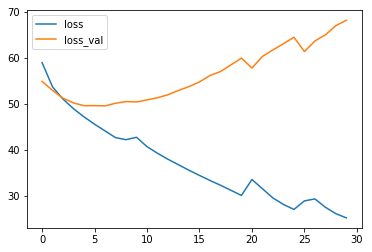

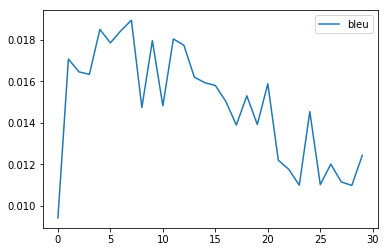

In [16]:
for key, val in history.items():
        if "loss" in key:
            plt.plot(val, label=key)
plt.legend()
plt.show()
for key, val in history.items():
    if "bleu" in key:
        plt.plot(val, label=key)
plt.legend()
plt.show()

In [54]:
i = 701
a = data["test"]["codes"][i]
print(a)
print("-"*20)
print_traverse(data["test"]["trees"][i])

Type.objects.filter(type=typeImInterestedIn)
--------------------
Module
  Expr
    Call
      Attribute
        Attribute
          Name
            Type
            Load
          objects
          Load
        filter
        Load
      keyword
        type
        Name
          typeImInterestedIn
          Load
